In [589]:
import numpy as np
from matplotlib import pyplot as plt
import time

We begin with the Green's function equation:

$ \nabla^2 G(\textbf{r}-\textbf{r}') = \delta(\textbf{r}-\textbf{r}')$

which in 2D has the solution:

$ G(\textbf{r}-\textbf{r}') = \frac{1}{2 \pi} \log{(|\textbf{r}-\textbf{r}'|)} $

This obviously diverges when $\textbf{r} = \textbf{r}'$, so we will have to be careful about how we treat that point. We can do this by first assigning $G[0,0]$ some arbitrary value (here I set it to $0$), and then replacing this value by $G[0,0] = G[1,0] - \frac{1}{4}$ using the nearest neighbor averaging interpretation of the discrete laplacian and also using radial symmetry of the problem. Then I compute $\rho[i,j] = (G[i,j] - \text{nearest neighbor average around }G[i,j])$. Noting that $G[i,j] \propto \rho[0,0]$ , I rescale $G \rightarrow \frac{G}{\rho[0,0]}$. Finally I change the zero of the potential by doing $G[i,j] \rightarrow G[i,j]-G[0,0]+1$ which then makes $G[0,0] = 1$. I finally compute $\rho$ using the rescaled $G$ to confirm that indeed $\rho[0,0] = 1$.

Note: There seems to be a sign issue with how we do electrostatics in this class. In theory, we have 

$ \nabla^2 V(\textbf{r}) = - \rho(\textbf{r})$ and $\nabla^2 G(\textbf{r}-\textbf{r}') = -\delta(\textbf{r}-\textbf{r}')$

but here I drop the negative signs in both equations (since Jon seemed to drop them in class). This is fine in this problem since we are not terribly concerned with the exterior boundary, but if we were, then we might have to be careful with how we incorporate them.

We will set $G$ to zero on the boundary of the larger grid. This is just an arbitrary choice of boundary condition for $G$.

Also, the actual grid we will use for this problem will be 128-by-128. I need to compute the Green's function on a much larger grid since I will be using FFTs later for some convolutions and I would like to avoid the actual physical system to wrap around on itself. So for this I use a 256-by-256 grid to compute the Green's function and will use zero padding for the charge density defined on the actual physical grid to make the edge effects negligible. The choice of $2n$ in particular is motivated by the fact that `np.fft.rfftn` will return an output of size 256-by-129 and so I can conveniently pad my charge density array by 128 zeros on each axis to make it 256-by-256 (whose fft will be 256-by-129 as well). I could have (and did initially) use a larger grid but the plot of the electric field was too dense to be able to make anything out. The code will work quite efficiently for larger grids as well.

A bunch of this code is copied from Jon's git from an earlier course repo, with minor modifications.

In [590]:
def greens(n,ndim=2):
    dx=np.arange(n)
    dx[n//2:]=dx[n//2:]-n
    if ndim==2:
        pot=np.zeros([n,n])
        xmat,ymat=np.meshgrid(dx,dx)
        dr=np.sqrt(xmat**2+ymat**2)
        dr[0,0]=1 # to avoid log divergence, we change this value for pot immediately below
        pot=np.log(dr)/2/np.pi  # analytic green's function
        pot=pot-pot[n//2,n//2]  # set it so the potential at the edge goes to zero.
        pot[0,0]=pot[0,1]-0.25 # put in correct value for origin
        return pot

# compute rho given a potential field
def pot2rho(V):
    nn_ave = (np.roll(V,1,0) + np.roll(V,-1,0) + np.roll(V,1,1) + np.roll(V,-1,1)) / 4
    return V-nn_ave

n=128

#get the green's function
kernel=greens(2*n,2)
rho_firstpass = pot2rho(kernel)
kernel = kernel/rho_firstpass[0,0]
kernel = kernel-kernel[0,0]+1
rho_inferred = pot2rho(kernel)
kernelft=np.fft.rfft2(kernel)
print(kernelft.shape)
print("V[0,0] = ", kernel[0,0])
print("rho[0,0] = ", rho_inferred[0,0])
print("V[1,0] = ", kernel[1,0])
print("V[2,0] = ", kernel[2,0])
print("V[5,0] = ", kernel[5,0])

(256, 129)
V[0,0] =  1.0
rho[0,0] =  1.0
V[1,0] =  0.0
V[2,0] =  -0.4412712003053034
V[5,0] =  -1.024599997453552


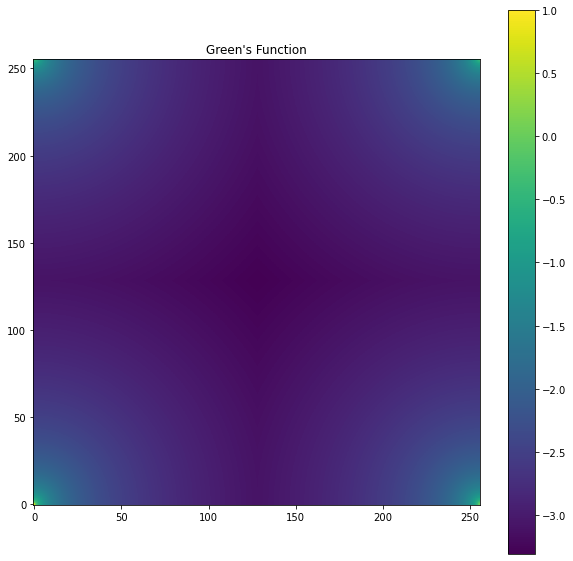

In [591]:
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(kernel, origin='lower')
plt.colorbar()
plt.title("Green's Function")
plt.show()

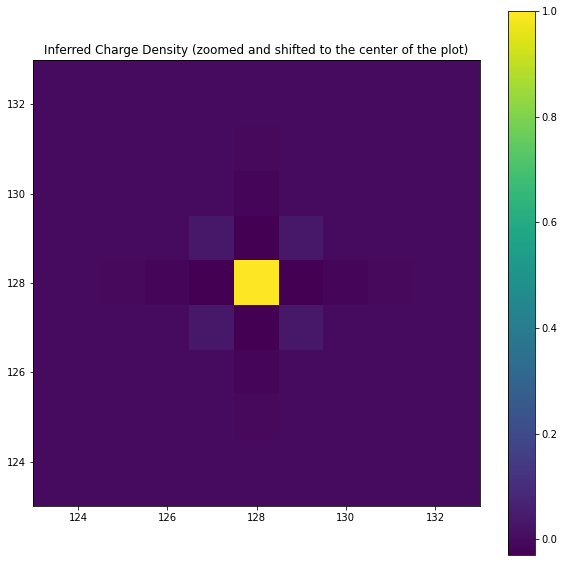

Actual origin is at [0,0], and the charge density is 0 everywhere outside the plotted region


In [592]:
plt.imshow(np.fft.fftshift(rho_inferred), origin='lower')
plt.title("Inferred Charge Density (zoomed and shifted to the center of the plot)")
plt.xlim((2*n)//2-5,(2*n)//2+5)
plt.ylim((2*n)//2-5,(2*n)//2+5)
plt.colorbar()
plt.show()
print("Actual origin is at [0,0], and the charge density is 0 everywhere outside the plotted region")

Now I begin the set-up for the conjugate gradient. We want to solve for `rho` given `V`, `G` and that `V = convolution(G,rho)`. It is important to note there that while we conventionally write the linear equation for conjugate gradient as $ \textbf{A} x = b$ where $x, b$ are some 1-by-m (or m-by-1) arrays, it is not actually explicitly necessary to have $\textbf{A}$ as a matrix. All we need to know are that $\textbf{A}$ corresponds to a linear operator and given ANY vector $x$, I can give you a vector corresponding to $\textbf{A}x$. This is exactly what we are going to do.

We start on our 128-by-128 grid. Someone has given us a set of indices, and the values of $V$ on those locations. We can make a mask out of the specified indices and a vector `V` corresponding to the values of $V$ in the order specified by the mask. For the purposes of the conjugate gradient algorithm, we would like our right hand side (`convolution(G,rho)`) to likewise produce a vector of the same shape as `V`, indexed in the same order according to the mask which will give us our prediction for what `V` should be. Then we can run the conjugate gradient algorithm as discussed in class using the standard template Jon coded up. Here is how I do this. I start with a guess for `rho` of the same shape as `V`. Using the mask I make, I convert `rho` into a 128-by-128 matrix `rhomat` that I convolve with my 256-by-256 green's function array that I computed above (after doing some padding), which gives me back a 128-by-128 array (after doing some array splicing). I then read out the values of this convolved matrix along the mask to get my rhs vector, let's call is `Ax`. I can technically replace `rho` with any vector, say the `pk` we use for the conjugate gradient and get the corresponding `Ax`. Then we can run the conjugate gradient algorithm (`b` $\equiv$ `V`, `rho` $\equiv$ `x`):

1. Start with a guess `x`.

2. Compute `Ax`, and `r = b-Ax`.

3. Set `p = r`, `rsqr = np.sum(r**2)`

4. Begin loop:

    (a) Compute `Ap` and `alpha=np.sum(r*r)/np.sum(Ap*p)`
    
    (b) `x = x + alpha*p`
    
    (c) `r = r-alpha*Ap`
    
    (d) `rsqr_new = np.sum(r*r)`
    
    (e) `beta=rsqr_new/rsqr`
    
    (f) `p=r+beta*p`
    
    (g) `rsqr = rsqr_new`

5. Loop till happy and return x once you're done


I will need two helper functions. First I need a function `rho2pot` that will compute $ V = G \star \rho$ given a n-by-n array `rho`. I pad the `rho` array as discussed above and then use the Fourier transform to compute the convolution in the usual way (after padding this gives me a 2n-by-2n array). I then splice out the actual (physical) n-by-n array and return it.

I also need a function `rho2pot_masked` that will take in a *masked* version of `rho`, i.e. a *vector* `rho` and return a *vector* `pot`. Here I also have the option to return a full array `potmat` if needed.

In [593]:
def rho2pot(rho,kernelft):
    tmp=rho.copy()
    tmp=np.pad(tmp,(0,mask.shape[0]))
    tmpft=np.fft.rfftn(tmp)
    tmp=np.fft.irfftn(tmpft*kernelft)
    tmp=tmp[:rho.shape[0],:rho.shape[1]]
    return tmp

def rho2pot_masked(rho,mask,kernelft,return_mat=False):
    #rho is a 1-by-m vector. Convert to n-by-n matrix
    rhomat=np.zeros(mask.shape)
    rhomat[mask]=rho
    #compute the potential from this rho
    potmat=rho2pot(rhomat,kernelft)
    
    if return_mat:  # if we want the potential everywhere (for plotting)
        return potmat
    else:  # if we want back a 1-by-m vector (for conjugate gradient)
        return potmat[mask]

Now we do our conjugate gradient algorithm as outlined earlier. The mask is used to go from a n-by-n array to a 1-by-m vector and back.

In [594]:
#convolve the density with the Greens function to get the potential
def cg(rhs,x0,mask,kernelft,niter, tol=1e-12):
    """cg(rhs,x0,mask,niter) - this runs a conjugate gradient solver to solve Ax=b where A
    is the Laplacian operator interpreted as a matrix, and b is the contribution from the 
    boundary conditions.  Incidentally, one could add charge into the region by adding it
    to b (the right-hand side or rhs variable).  Other than carrying around helper variables
    (like mask and kernelft), this is once again bog-standard conjugate gradient."""

    t1=time.time()
    Ax=rho2pot_masked(x0,mask,kernelft)
    r=rhs-Ax
    #print('sum here is ',np.sum(np.abs(r[mask])))
    p=r.copy()
    x=x0.copy()
    rsqr=np.sum(r*r)
    
    print('starting rsqr is ',rsqr)
    
    tolerance = 1.0
    
    while tolerance>=tol:
        Ap=rho2pot_masked(p,mask,kernelft)
        alpha=np.sum(r*r)/np.sum(Ap*p)
        x=x+alpha*p
        r=r-alpha*Ap
        rsqr_new=np.sum(r*r)
        beta=rsqr_new/rsqr
        p=r+beta*p
        tolerance = rsqr_new
        rsqr=rsqr_new
    t2=time.time()
    print('final rsqr is ',rsqr,' after ',t2-t1,' seconds')
    return x

plt.ion()

Now we set up our physical grid, boundary conditions, mask and the given potential array along the mask.

In [595]:
#do our usual setting up of boundary conditions with the potential held to zero on the edges
bc=np.zeros([n,n])
mask=np.zeros([n,n],dtype='bool')

bc = np.zeros([n,n])
mask = np.zeros([n,n], dtype='bool')
bc[0,:] = 0.0
bc[-1,:] = 0.0
bc[:,0] = 0.0
bc[:,-1] = 0.0

mask[0,:] = True
mask[-1,:] = True
mask[:,0] = True
mask[:,-1] = True

# Place square box at fixed potential
box_width = 20
bc[n//2-box_width:n//2+box_width, n//2-box_width:n//2+box_width] = 1.0
mask[n//2-box_width:n//2+box_width,n//2-box_width:n//2+box_width] = True

#we're solving for the charge that gives us the potential, so 
#our right-hand side is the potential on the mask.  
V=bc[mask]
rho0=0*rhs
# this should give us the charge on the boundary that matches the potential
# this is a vector of the same shape as V above
rho_out=cg(V,rho0,mask,kernelft,40)

#convert to n-by-n matrix for plotting
rho_final = np.zeros([n,n])
rho_final[mask] = rho_out

# convert the charge on the boundary to the potential everywhere in space
# for plotting purposes
pot=rho2pot_masked(rho_out,mask,kernelft,True)

starting rsqr is  1600.0
final rsqr is  2.1119770568862112e-13  after  0.05262589454650879  seconds


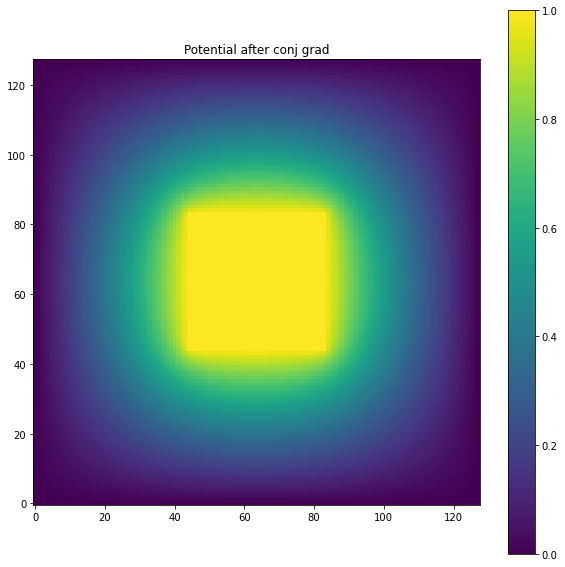

In [596]:
plt.imshow(pot, origin='lower')
plt.title("Potential after conj grad")
plt.colorbar()
plt.show()

In [597]:
print("Average potential inside box: ", np.mean(pot[n//2-box_width+1:n//2+box_width-1, n//2-box_width+1:n//2+box_width-1]))
print("Standard dev of potential inside box: ", np.std(pot[n//2-box_width+1:n//2+box_width-1, n//2-box_width+1:n//2+box_width-1]))

Average potential inside box:  0.9999999999632366
Standard dev of potential inside box:  1.109437289154541e-08


The potential is indeed very close to constant inside the box, and is very close to 1 as we'd expect analytically.

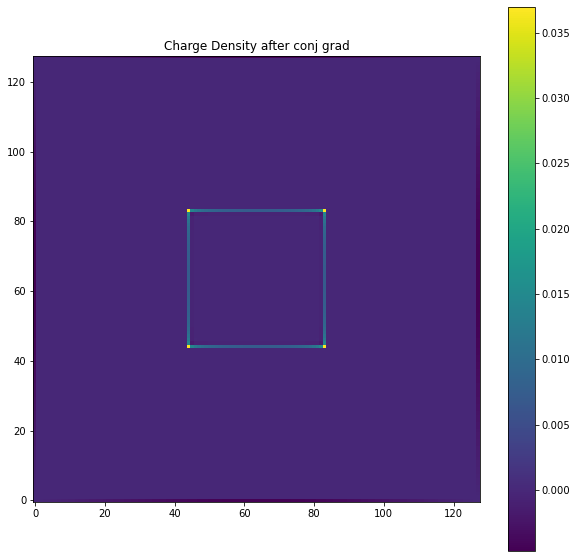

In [598]:
plt.imshow(rho_final, origin='lower')
plt.title("Charge Density after conj grad")
plt.colorbar()
plt.show()

In [599]:
print("Average potential inside box: ", np.mean(rho_final[n//2-box_width+1:n//2+box_width-1, n//2-box_width+1:n//2+box_width-1]))
print("Standard dev of potential inside box: ", np.std(rho_final[n//2-box_width+1:n//2+box_width-1, n//2-box_width+1:n//2+box_width-1]))

Average potential inside box:  -4.247291651273361e-05
Standard dev of potential inside box:  0.00014446963773141313


The charge is indeed very close to zero everywhere inside the conducting box and is concentrated at the surface of the box, again, as we'd expect from theory.

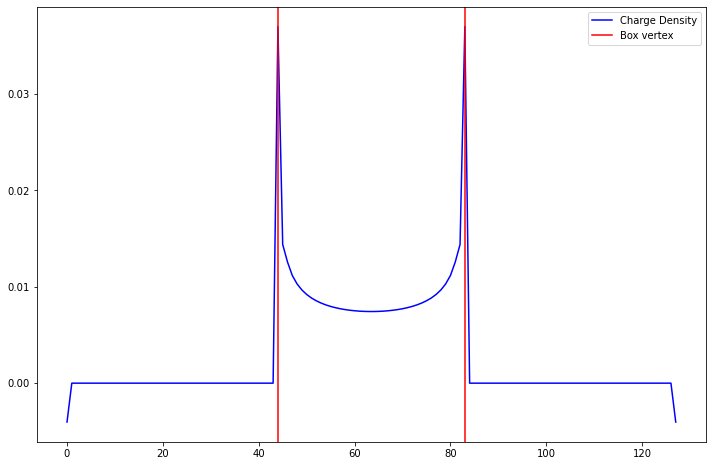

In [600]:
side = np.arange(n//2-box_width,n//2+box_width)
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(rho_final[:, n//2+box_width-1], c='b', label='Charge Density')
plt.axvline(n//2-box_width, c='r', label='Box vertex')
plt.axvline(n//2+box_width-1,c='r')
plt.legend()
plt.show()

The above plot shows the charge density along a 1-d splice of the full charge array. The region in between the red lines gives the charge density along one side of the box.

Next we use $\textbf{E} = - \nabla V$ to get the Electric Field everywhere, and do a quiver plot to see what it looks like. I overlay this with a contour plot of the potential. Zooming in to the image verifies that (1) The field is indeed (very close to) zero inside box since that is an equipotential region, and (2) the field is everywhere perpendicular to equipotential curves (in particular notice the vertices of the box, where the field shows weird edge effects in order to be perpendicular to the equipotential curves)! 

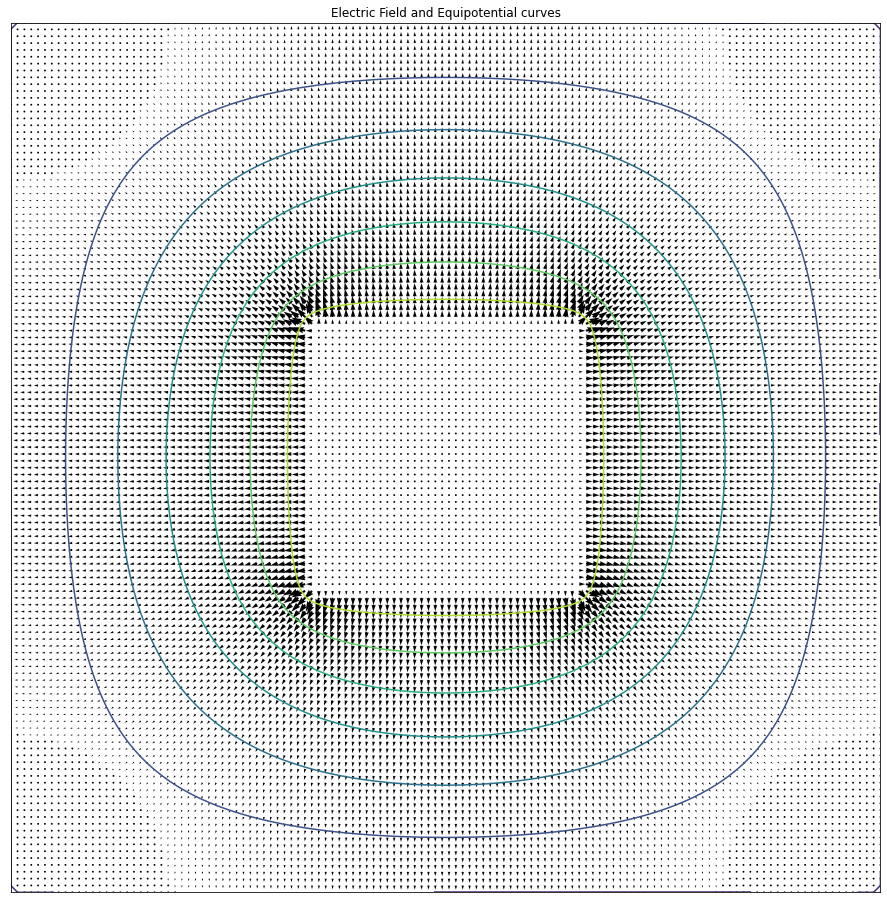

In [601]:
# Compute electric field
dy, dx = np.gradient(pot)
Ey, Ex = -dy, -dx

# Plot
x = np.arange(n)
X, Y = np.meshgrid(x, x)

fig, ax = plt.subplots(figsize=(16,16))
ax.quiver(X, Y, Ex , Ey)
ax.contour(pot)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')
ax.set_title("Electric Field and Equipotential curves")
plt.show()